# Problem Statement

Expedia receives millions of users per day who are hoping to plan and book their ideal vacation. They are trying to find a better way to offer the best hotels for the customer so they can easily book the hotel of their choosing. More bookings means an increase Expedia's overall revenue.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

My goal is to predict the "hotel cluster" for a user based on their search criteria and attributes.

# About the the Data

I received the data from Kaggle and was given a training set and test set. For this analysis, I will be using only the training set as the test set is for Kaggle submissions and does not have the targeted data. The training set consisted of random searches from Jan 2013 - Dec 2014.

An important thing to note, the data is completely anonymized. Anything in relation to a location or name was given a numerical value. This really limited what insights I could draw from the data except from what was on the surface level.

## Data Dictionary

|Column name|Description|Data type|
|-----------|-----------|---------|
|date_time|Timestamp|string|
|site_name|ID of the Expedia point of sale(i.e.Expedia.com,Expedia.co.uk, Expedia.co.jp, ...)|int|
|posa_continent|ID of continent associated with site_name|int|
|user_location_country|The ID of the country the customer is located|int|
|user_location_region|The ID of the region the customer is located|int|
|user_location_city|The ID of the city the customer is located	|int|
|orig_destination_distance|Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated|float|
|user_id|ID of user|int|
|is_mobile|1 when a user connected from a mobile device, 0 otherwise|int|
|is_package|1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise|int|
|channel|ID of a marketing channel|int|
|srch_ci|Checkin date|string|
|srch_co|Checkout date|string|
|srch_adults_cnt|The number of adults specified in the hotel room|int|
|srch_children_cnt|The number of (extra occupancy) children specified in the hotel room|int|
|srch_rm_cnt|The number of hotel rooms specified in the search	|int|
|srch_destination_id|ID of the destination where the hotel search was performed|int|
|srch_destination_type_id|Type of destination|int|
|hotel_continent|Hotel continent|int|
|hotel_country|Hotel country|int|
|hotel_market|Hotel market|int|
|is_booking|1 if a booking, 0 if a click|int|
|cnt|Numer of similar events in the context of the same user session|int|
|hotel_cluster|ID of a hotel cluster|int|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cross_validation import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [35]:
expedia = pd.read_csv("../../Datasets/Expedia Data/train.csv", nrows=30000)

In [36]:
expedia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
date_time                    30000 non-null object
site_name                    30000 non-null int64
posa_continent               30000 non-null int64
user_location_country        30000 non-null int64
user_location_region         30000 non-null int64
user_location_city           30000 non-null int64
orig_destination_distance    18944 non-null float64
user_id                      30000 non-null int64
is_mobile                    30000 non-null int64
is_package                   30000 non-null int64
channel                      30000 non-null int64
srch_ci                      29981 non-null object
srch_co                      29981 non-null object
srch_adults_cnt              30000 non-null int64
srch_children_cnt            30000 non-null int64
srch_rm_cnt                  30000 non-null int64
srch_destination_id          30000 non-null int64
srch_destination_type_id     30000 n

In [37]:
expedia.head(3)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1


In [38]:
exp = pd.DataFrame(expedia)

In [39]:
exp['date_time'] = pd.to_datetime(exp['date_time'])
exp['srch_ci'] = pd.to_datetime(exp['srch_ci'])
exp['srch_co'] = pd.to_datetime(exp['srch_co'])

# Summary Statistics

66     17632
69      2797
205     2201
3       1166
46       951
Name: user_location_country, dtype: int64


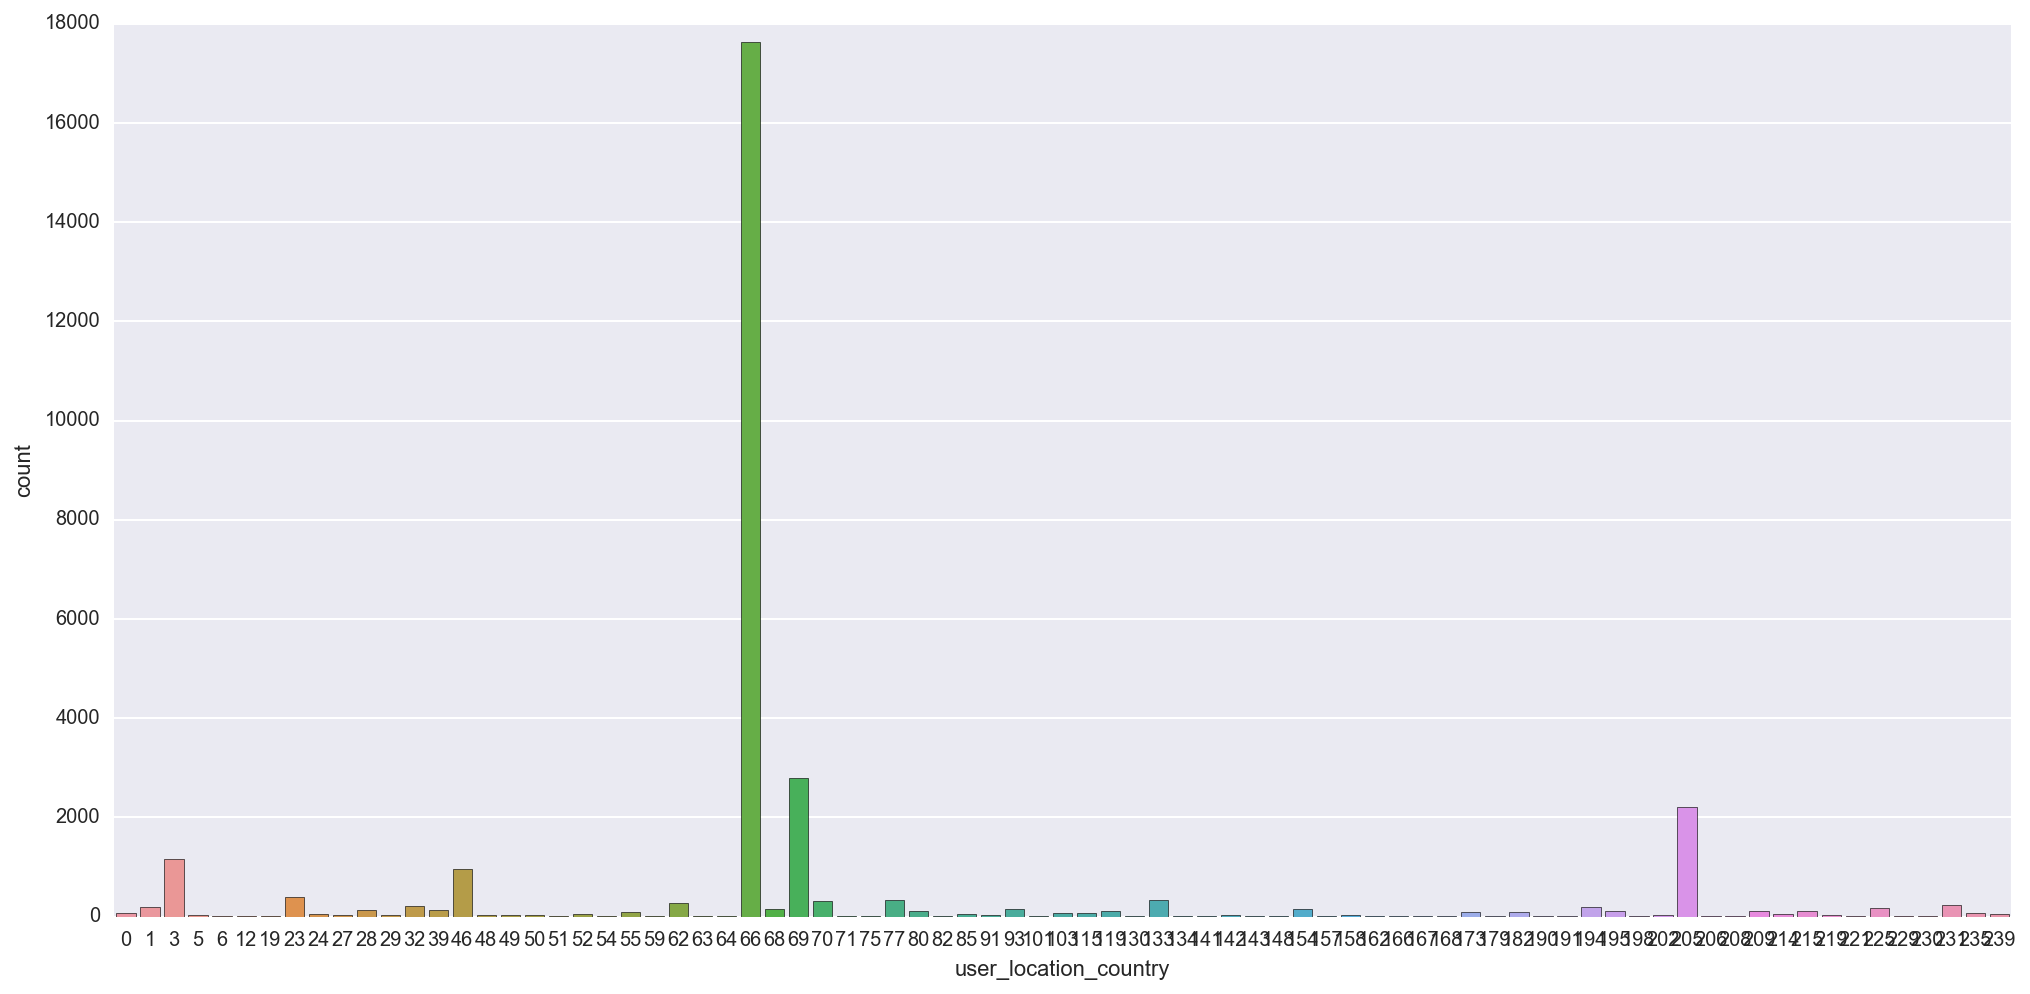

In [40]:
# What country are most of the searches from?

print exp['user_location_country'].value_counts().head(5)

plt.figure(figsize=(17,8))
# exp['user_location_country'].value_counts().head(10).plot(legend=True, kind='bar')
sns.countplot(exp['user_location_country'], data=exp)

In [41]:
# Booked subset
booked = exp[exp['is_booking'] == 1]

0    27489
1     2511
Name: is_booking, dtype: int64


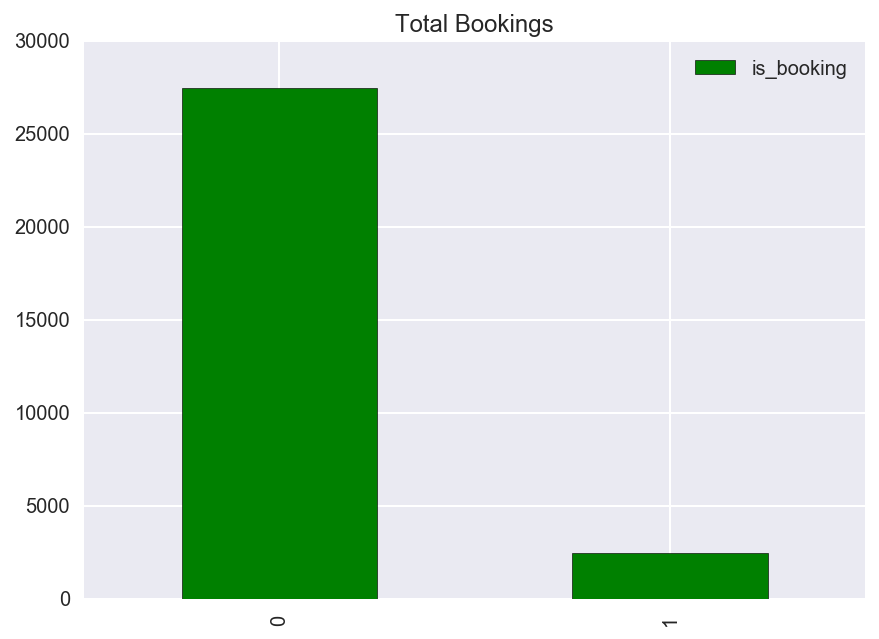

In [42]:
# How many bookings?

plt.figure(figsize=(7,5))
print exp['is_booking'].value_counts()
exp['is_booking'].value_counts().plot(legend=True, kind='bar', color='green', title='Total Bookings')

0    22658
1     7342
Name: is_package, dtype: int64
----------------------------
0    2126
1     385
Name: is_package, dtype: int64


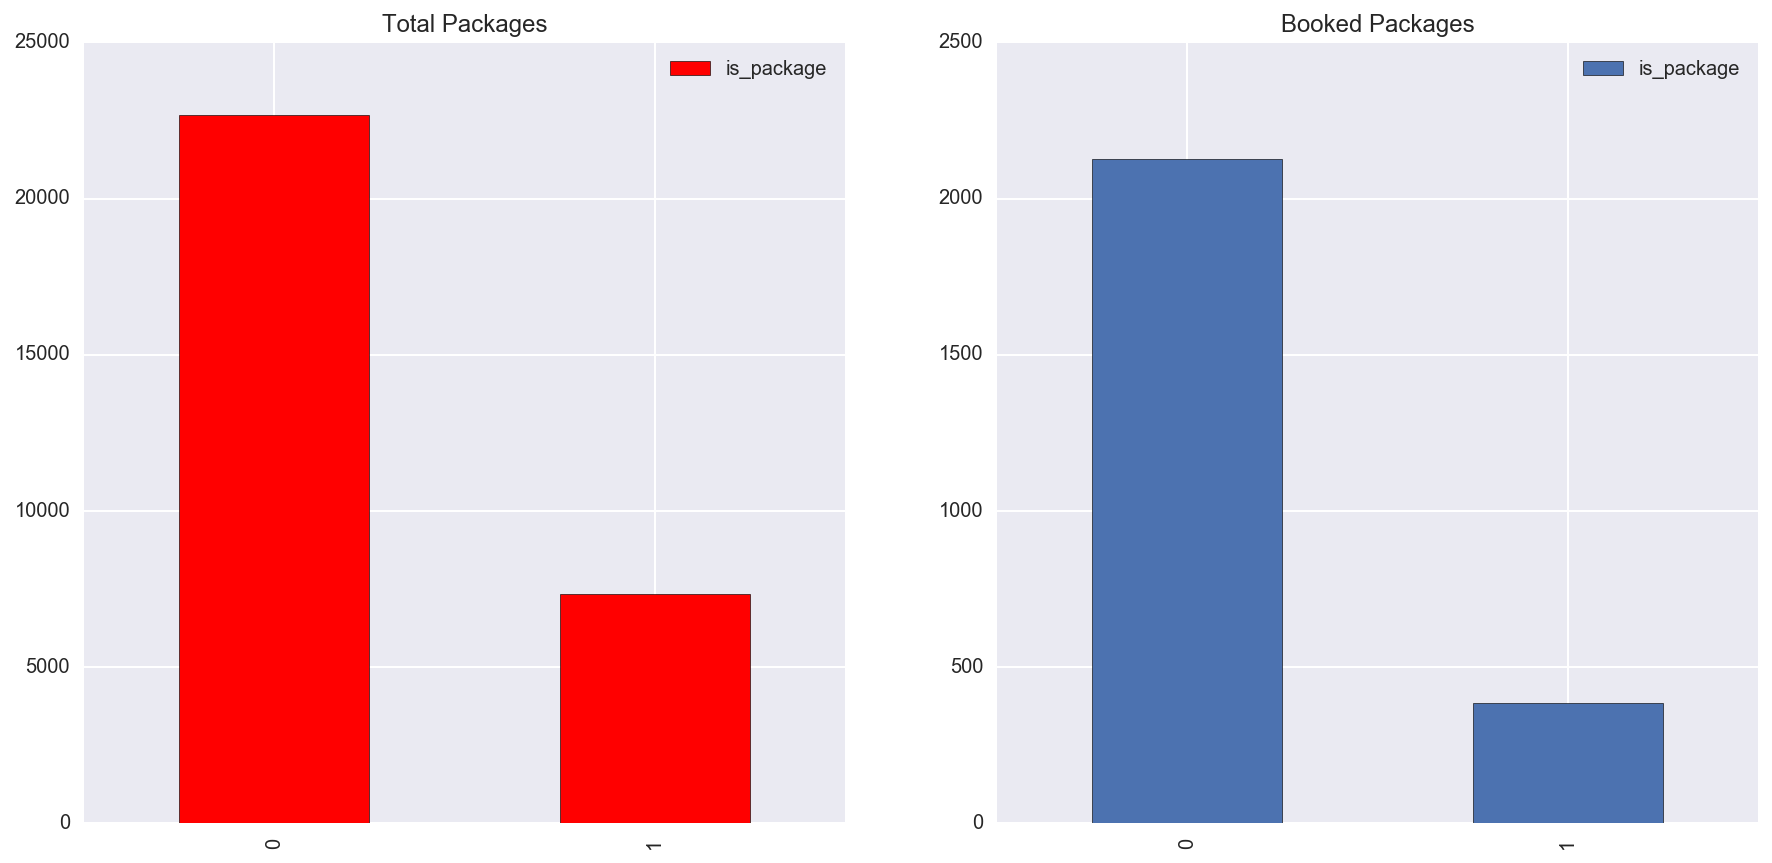

In [43]:
# Packages
# booked packages

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,7))

print exp['is_package'].value_counts()
print "----------------------------"
print booked['is_package'].value_counts()

exp['is_package'].value_counts().plot(legend=True, color='red', kind=('bar'), ax=axis1, title='Total Packages')
booked['is_package'].value_counts().plot(legend=True, kind=('bar'), ax=axis2, title='Booked Packages')

0    25919
1     4081
Name: is_mobile, dtype: int64
----------------------------
0    2278
1     233
Name: is_mobile, dtype: int64


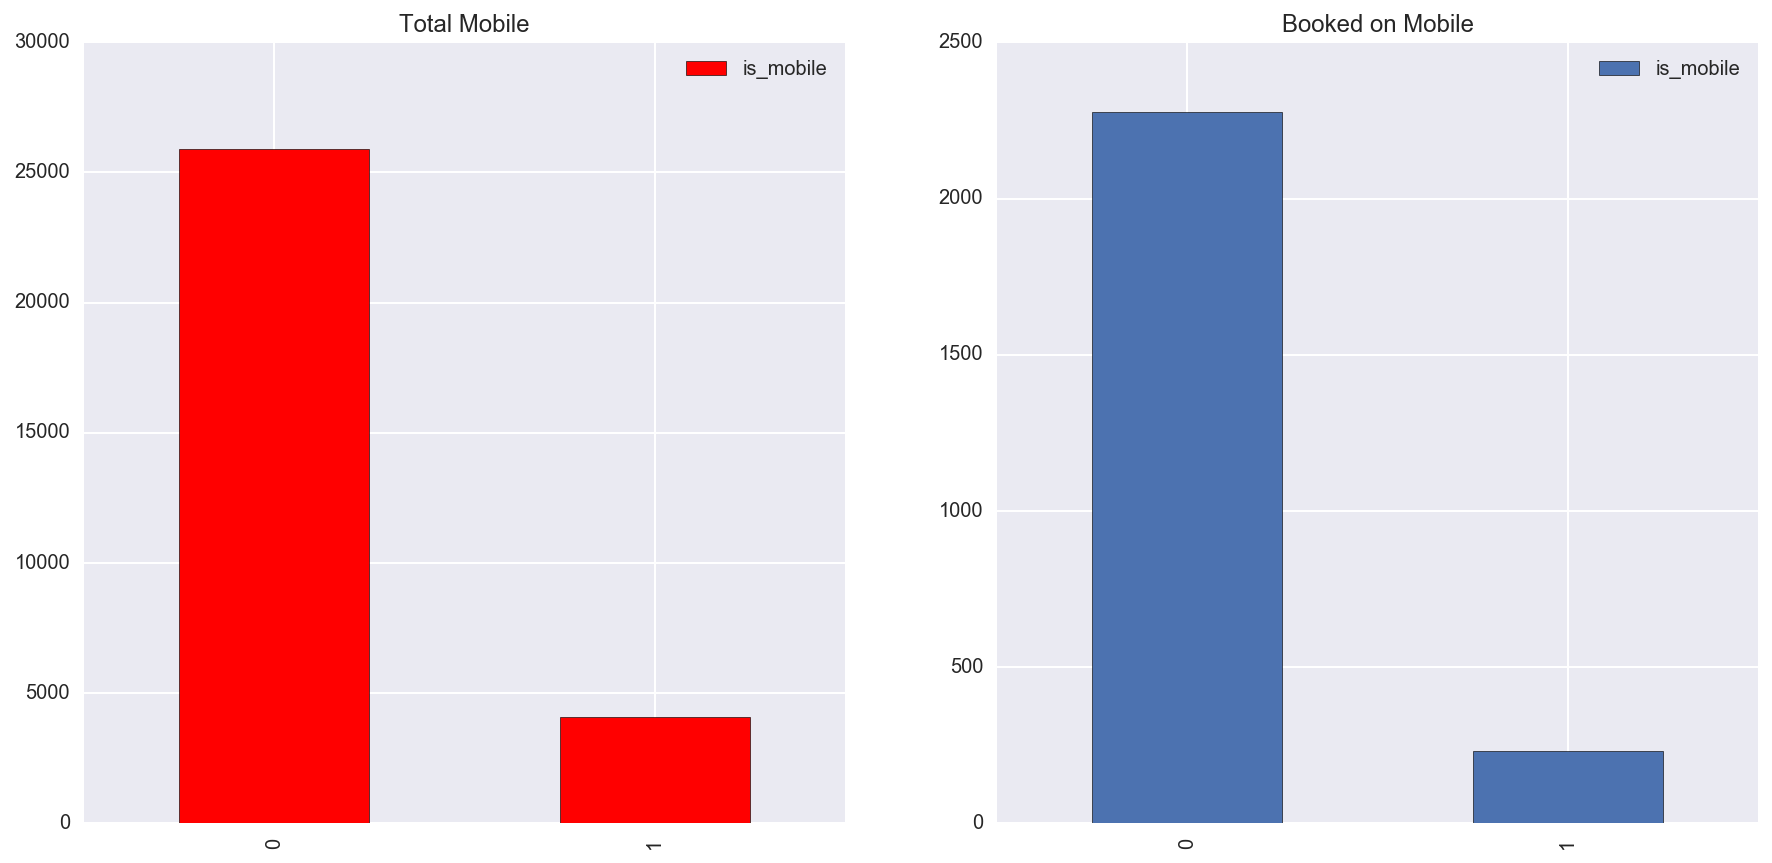

In [44]:
# Mobile
# booked Mobile

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,7))

print exp['is_mobile'].value_counts()
print "----------------------------"
print booked['is_mobile'].value_counts()

exp['is_mobile'].value_counts().plot(legend=True, color='red', kind=('bar'), ax=axis1, title='Total Mobile')
booked['is_mobile'].value_counts().plot(legend=True, kind=('bar'), ax=axis2, title='Booked on Mobile')

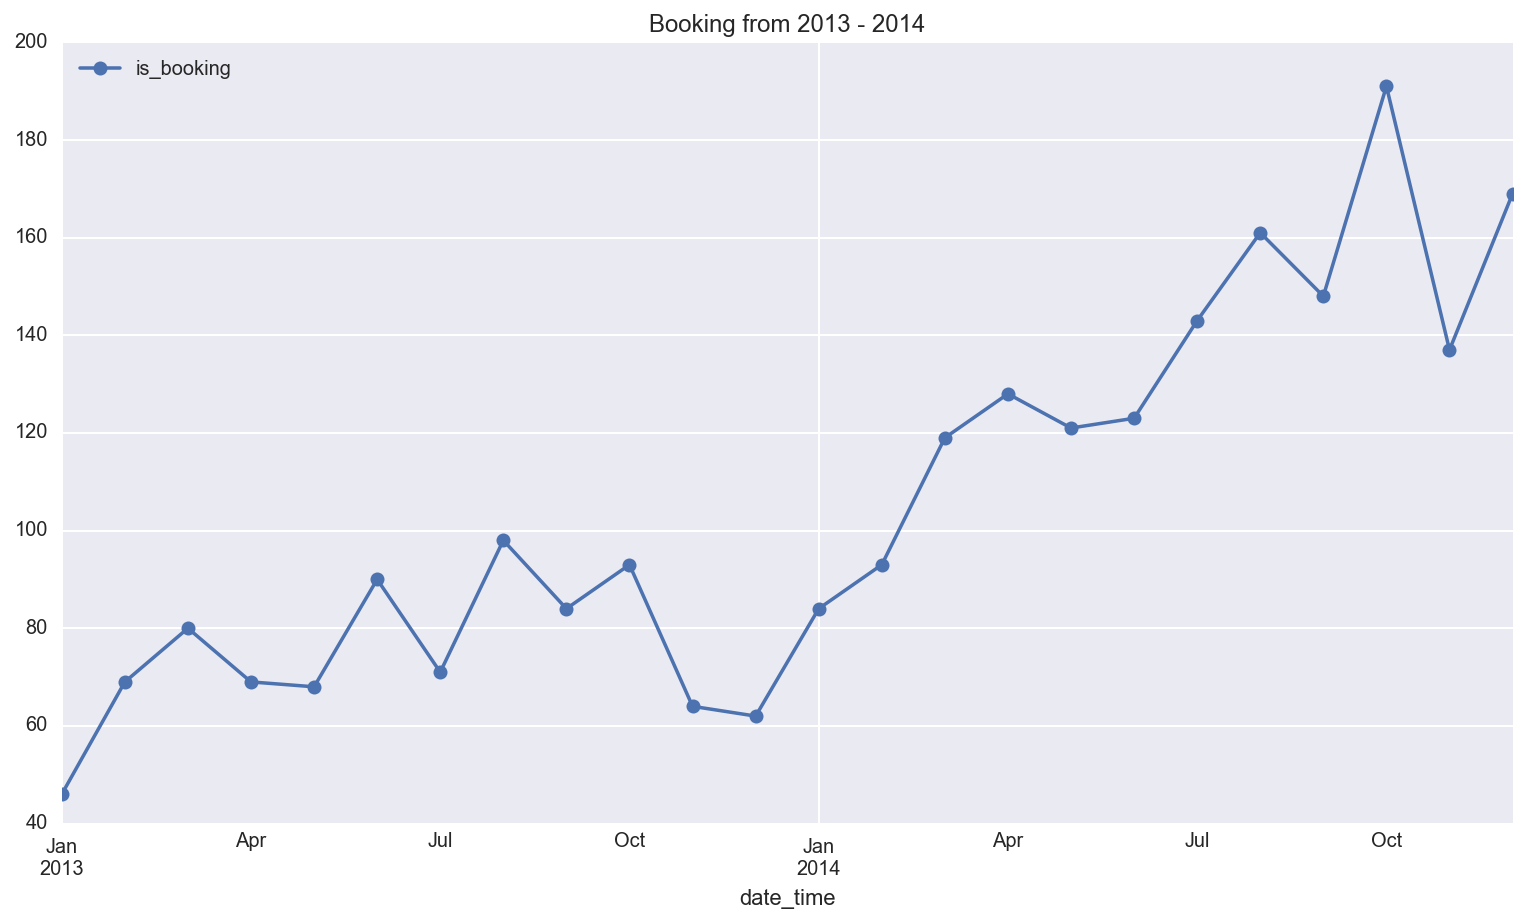

In [45]:
# The number of bookings during the year

date_booked = booked.groupby(booked.date_time.dt.to_period("M"))['is_booking'].sum()

fig = plt.figure(figsize=(13,7))
date_booked.plot(legend=True, marker='o', title="Booking from 2013 - 2014")

50     1382
198     127
70      122
105      88
204      68
Name: hotel_country, dtype: int64


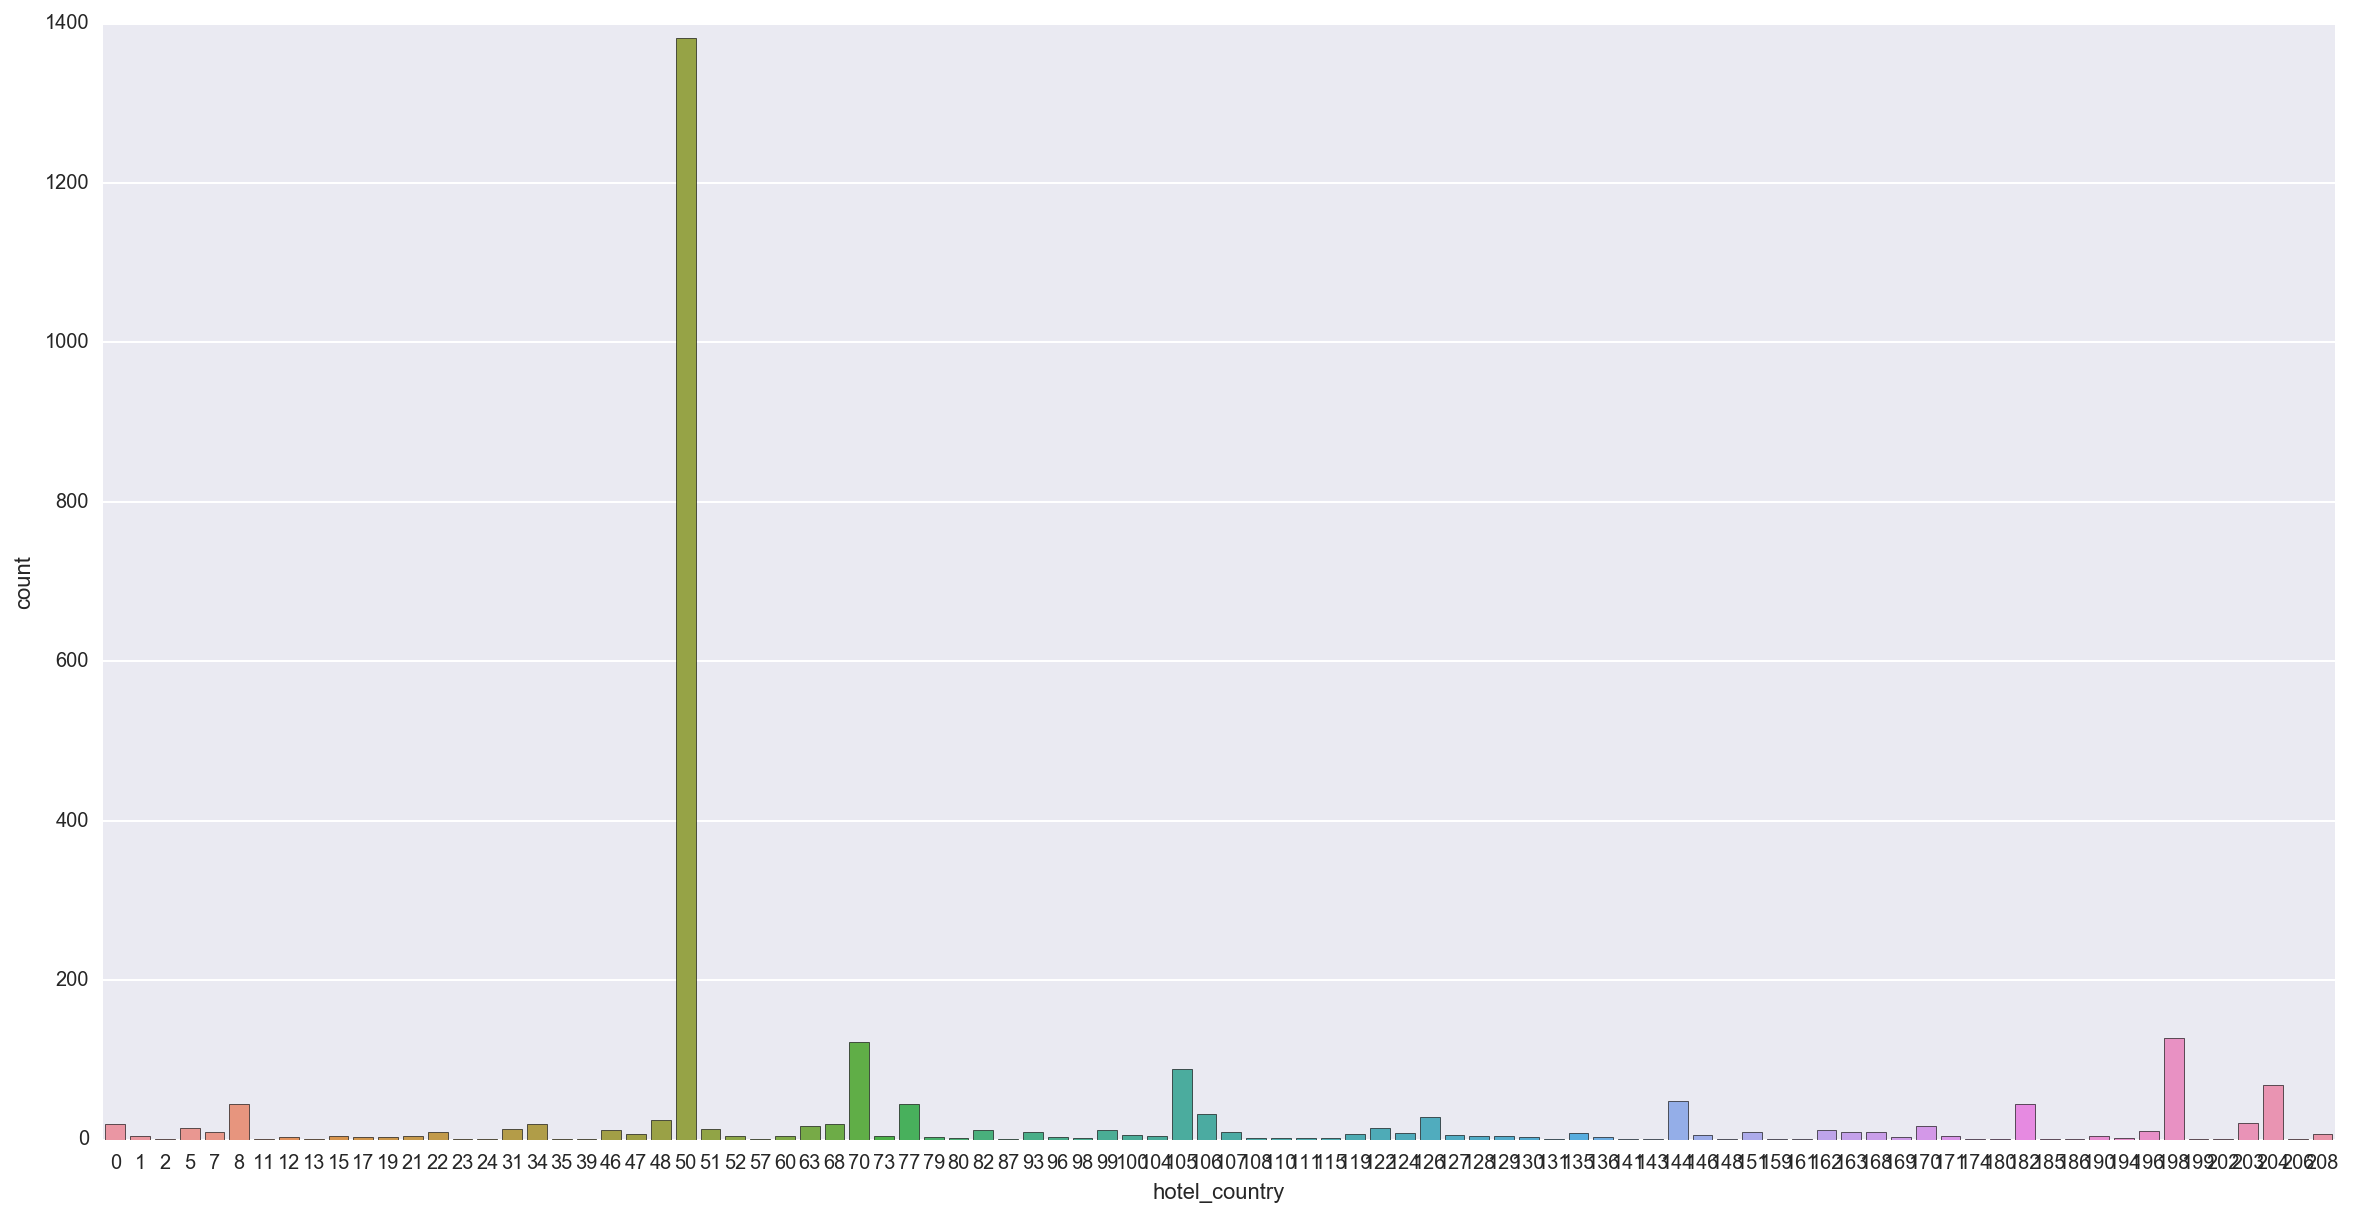

In [46]:
# What country do most people travel to?

print booked['hotel_country'].value_counts().head()

fig = plt.figure(figsize=(20,10))

sns.countplot(booked['hotel_country'], data=booked)

91    854
64    704
41    666
48    568
65    503
Name: hotel_cluster, dtype: int64


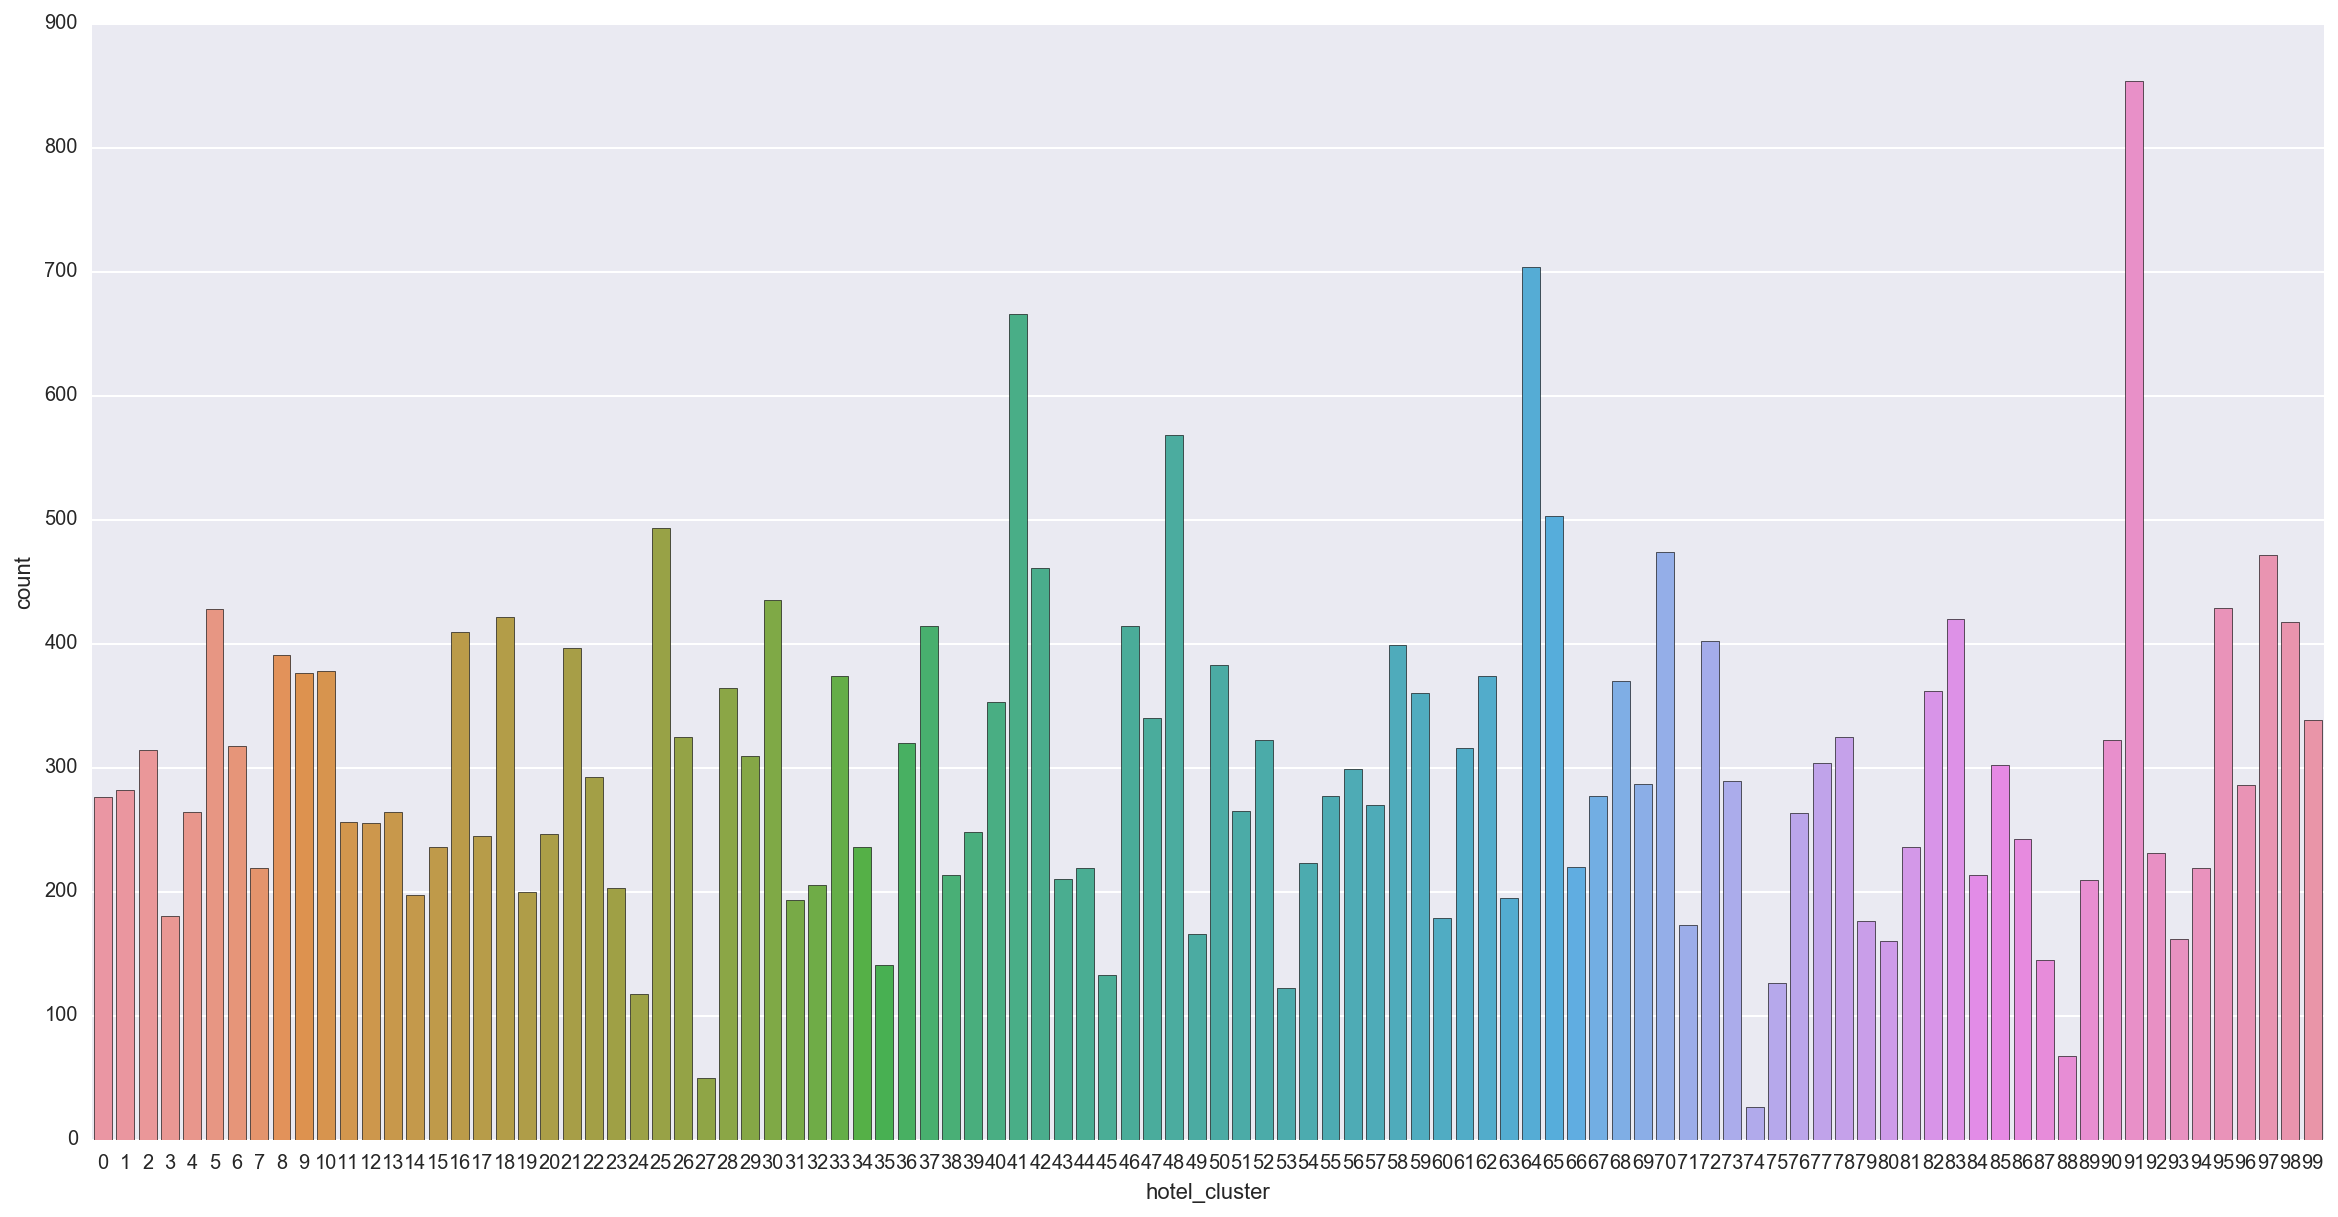

In [47]:
# What country do most people travel to?

print exp['hotel_cluster'].value_counts().head()

fig = plt.figure(figsize=(20,10))

sns.countplot(exp['hotel_cluster'], data=exp)

In [48]:
# Create a copy and remove features that do not relate to hotel cluster

exp2 = exp.copy()

exp2.drop(exp2[['date_time', 'srch_ci', 'srch_co', 'channel', 
                'orig_destination_distance', 'hotel_cluster']], axis=1, inplace=True)

In [49]:
# Taking months and days out of the date_time column and using them as predictors

def month_day_addition(df,tar_col):
    months, days = [],[]
    for i in df[tar_col]:
        months.append(i.month)
        days.append(i.day)
    return days, months

exp2['day'], exp2['month'] = month_day_addition(exp, 'date_time')

In [50]:
exp2.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,day,month
0,2,3,66,348,48862,12,0,1,2,0,1,8250,1,0,3,2,50,628,11,8
1,2,3,66,348,48862,12,0,1,2,0,1,8250,1,1,1,2,50,628,11,8
2,2,3,66,348,48862,12,0,0,2,0,1,8250,1,0,1,2,50,628,11,8
3,2,3,66,442,35390,93,0,0,2,0,1,14984,1,0,1,2,50,1457,9,8
4,2,3,66,442,35390,93,0,0,2,0,1,14984,1,0,1,2,50,1457,9,8


In [78]:
# X is my predictors and Y is my target
X_cols = exp2.columns
X = exp2[X_cols].values
Y = expedia.hotel_cluster.values

# Creating my test sets and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Baseline Accuracy

Our baseline accuracy for the data is 2%. This indicates if someone were to guess which hotel a user will book, the liklihood of them guessing correctly would be 2%.

In [79]:
# find the mode of the dataset

from scipy.stats import mode
modearray = mode(Y)
print modearray

ModeResult(mode=array([91]), count=array([854]))


In [80]:
# Baseline accuracy as if you were going to guess the target

baseline = modearray[1][0]/float(Y.shape[0])
print "baseline score: ", baseline

baseline score:  0.0284666666667


# Modeling

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Decision Tree

In [82]:
dtc = DecisionTreeClassifier()

In [83]:
# Setting up parameters for my decision tree

dtc_params = {
    'criterion':['gini','entropy'],
    'max_features':['auto', None],
    'max_depth':[None,3,4,5],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,3,5,7]
}

dtc_gs = GridSearchCV(dtc, dtc_params, cv=5, n_jobs=-1)

In [84]:
# Using a function to fit my training data into the grisearched decision tree 

import time
def dtc_fit(model_gs, X, y):
    start = time.time()
    model_gs.fit(X,y)
    print "Runtime: %0.3f"%(time.time() - start)
    print "Gridsearch score: %0.4f"%(model_gs.best_score_) #gridsearch score
    print "Best parameter: ", model_gs.best_params_ # this gives me my best parameters for my model

dtc_fit(dtc_gs, X_train, Y_train)

Runtime: 116.671
Gridsearch score: 0.2471
Best parameter:  {'max_features': None, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}


In [85]:
# Fit the training data into my best paramaters to increase the accuracy of my model
dtc_best = dtc_gs.best_estimator_.fit(X_train, Y_train)

In [86]:
# This was the optimal score for the decision tree
dtc_best.score(X_test, Y_test)

0.27600000000000002

In [87]:
# This is the coefficients of the predictors. 
# Importance (coefficients) shows the impact the predictors have on the model
pd.DataFrame({'feature':X_cols, 'importance':dtc_best.feature_importances_}).sort_values(by='importance', 
                                                                                         ascending=False)

,feature,importance
17,hotel_market,0.209313
15,hotel_continent,0.111541
5,user_id,0.089478
18,day,0.087040
4,user_location_city,0.070052
19,month,0.067275
3,user_location_region,0.065856
16,hotel_country,0.062527
11,srch_destination_id,0.059552
14,cnt,0.051980


### Random Forest

In [88]:
rf = RandomForestClassifier()

In [89]:
# Setting up parameters for my random forest
# Random forest runs multiple decision trees just in case the decision tree was overfitting

rf_params = {
    'n_estimators':[10,20,30],
    'criterion':['gini','entropy'],
    'max_features':['auto',None],
    'max_depth':[None,2,3,4,5],
    'warm_start':[True]
}

rf_gs = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)

In [90]:
# Using a function to fit my training data into the grisearched random forest 

import time
def rf_fit(model_gs, X, y):
    start = time.time()
    model_gs.fit(X,y)
    print "Runtime: %0.3f"%(time.time() - start)
    print "Gridsearch score: %0.4f"%(model_gs.best_score_)
    print "Best parameter: ", model_gs.best_params_

rf_fit(rf_gs, X_train, Y_train)

Runtime: 431.950
Gridsearch score: 0.2736
Best parameter:  {'max_features': None, 'n_estimators': 30, 'criterion': 'entropy', 'warm_start': True, 'max_depth': None}


In [91]:
# Fit the training data into my best paramaters to increase the accuracy of my model
rf_best = rf_gs.best_estimator_
rf_best.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [92]:
# This was the optimal score for the random forest

print "Best Score", rf_best.score(X_test, Y_test)

Best Score 0.292444444444


In [93]:
# This is the coefficients of the predictors. 
# Importance (coefficients) shows the impact the predictors have on the model

pd.DataFrame({'feature':X_cols, 'importance':rf_best.feature_importances_}).sort_values(by='importance', 
                                                                                         ascending=False)

,feature,importance
17,hotel_market,0.204193
15,hotel_continent,0.107242
18,day,0.094098
5,user_id,0.086837
4,user_location_city,0.075392
19,month,0.068232
11,srch_destination_id,0.065803
3,user_location_region,0.063853
16,hotel_country,0.062648
14,cnt,0.045559


In [94]:
rf_predictions = rf_best.predict(X_test)
rf_confusion_matrix = pd.crosstab(Y_test, rf_predictions, rownames=['Actual'], colnames=['Predicted'])
# rf_confusion_matrix

In [95]:
rf_predictions

array([20,  5, 25, ..., 96, 46, 41])

In [96]:
# Classification report shows me the accuracy at which the random forest in predicting each classification (0-99)
print '\nClassification report for the Random Forest:\n\n', classification_report(Y_test, rf_predictions)


Classification report for the Random Forest:

             precision    recall  f1-score   support

          0       0.38      0.29      0.33        95
          1       0.50      0.64      0.56        86
          2       0.30      0.31      0.30        98
          3       0.18      0.13      0.15        60
          4       0.28      0.25      0.27        83
          5       0.16      0.17      0.17       125
          6       0.22      0.14      0.17       103
          7       0.35      0.39      0.37        67
          8       0.45      0.49      0.47       111
          9       0.37      0.35      0.36       120
         10       0.26      0.26      0.26       124
         11       0.28      0.28      0.28        76
         12       0.37      0.36      0.36        70
         13       0.24      0.31      0.27        64
         14       0.18      0.18      0.18        55
         15       0.19      0.18      0.18        74
         16       0.25      0.19      0.22       13

### KNeighbors Classifier

In [97]:
knn = KNeighborsClassifier()

In [98]:
# hone in on parameters
knn_params = {
    'n_neighbors':range(15,30,1), # originally started from 2-30 and tuned between 15-30 going through each iteration
    'weights':['distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'metric':['euclidean','manhattan'] # distance measurement between points
}

knn_gs = GridSearchCV(knn, knn_params, cv=5, n_jobs=-1)

In [99]:
# Using a function to fit my training data into the grisearched knn 

import time
def knn_fit(model_gs, X, y):
    start = time.time()
    model_gs.fit(X,y)
    print "Runtime: %0.3f"%(time.time() - start)
    print "Gridsearch score: %0.4f"%(model_gs.best_score_)
    print "Best parameter: ", model_gs.best_params_

knn_fit(knn_gs, X_train, Y_train)

Runtime: 517.086
Gridsearch score: 0.2633
Best parameter:  {'n_neighbors': 24, 'metric': 'manhattan', 'weights': 'distance', 'algorithm': 'ball_tree'}


In [100]:
# Fit the training data into my best paramaters to increase the accuracy of my model

knn_best = knn_gs.best_estimator_
knn_best.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=24, p=2,
           weights='distance')

In [101]:
# Best score with optimal parameters for knn
print "Best Score", knn_best.score(X_test, Y_test)

Best Score 0.287333333333


In [102]:
knn_predictions = knn_best.predict(X_test)
knn_confusion_matrix = pd.crosstab(Y_test, knn_predictions, rownames=['Actual'], colnames=['Predicted'])

In [103]:
knn_predictions

array([20, 58, 65, ..., 33, 46, 41])

In [104]:
# Classification report shows me the accuracy at which the KNeighbors classifier in predicting each classification (0-99)

print '\nClassification report for the KNN:\n\n', classification_report(Y_test, knn_predictions)


Classification report for the KNN:

             precision    recall  f1-score   support

          0       0.26      0.27      0.27        95
          1       0.42      0.62      0.50        86
          2       0.27      0.31      0.29        98
          3       0.17      0.17      0.17        60
          4       0.23      0.25      0.24        83
          5       0.12      0.18      0.15       125
          6       0.14      0.13      0.13       103
          7       0.30      0.40      0.35        67
          8       0.38      0.55      0.45       111
          9       0.29      0.35      0.31       120
         10       0.22      0.27      0.24       124
         11       0.21      0.32      0.26        76
         12       0.30      0.44      0.35        70
         13       0.30      0.39      0.34        64
         14       0.19      0.18      0.18        55
         15       0.18      0.19      0.18        74
         16       0.23      0.17      0.20       133
        

# Conclusion

In conclusion, Random Forest was the most optimal model giving 28% accuracy and KNN was in a close second at 27%. Overall these models were very similar, but tackled the problem in very different ways.